In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from tensorflow import data as tf_data
from tensorboard.plugins.hparams import api as hp
import keras_tuner as kt

from sklearn.model_selection import train_test_split

from preprocess_common import *

from record_save_load import *

In [3]:
class_names=['Human', 'AI']
AUTO = tf_data.AUTOTUNE # Parallelize data loading
#Hyperparameters
BATCH_SIZE = 64
BUFFER_SIZE = 1024
IMG_SIZE = (380,380)

SEED = 44

In [5]:
eff_train_ds = load_tfrecord("records/eff_ens_train.tfrecord", BATCH_SIZE, "efficientnet").repeat()
eff_val_ds = load_tfrecord("records/eff_ens_val.tfrecord", BATCH_SIZE, "efficientnet")
res_train_ds = load_tfrecord("records/res_ens_train.tfrecord", BATCH_SIZE, "resnet").repeat()
res_val_ds = load_tfrecord("records/res_ens_val.tfrecord", BATCH_SIZE, "resnet")

(380, 380, 3)


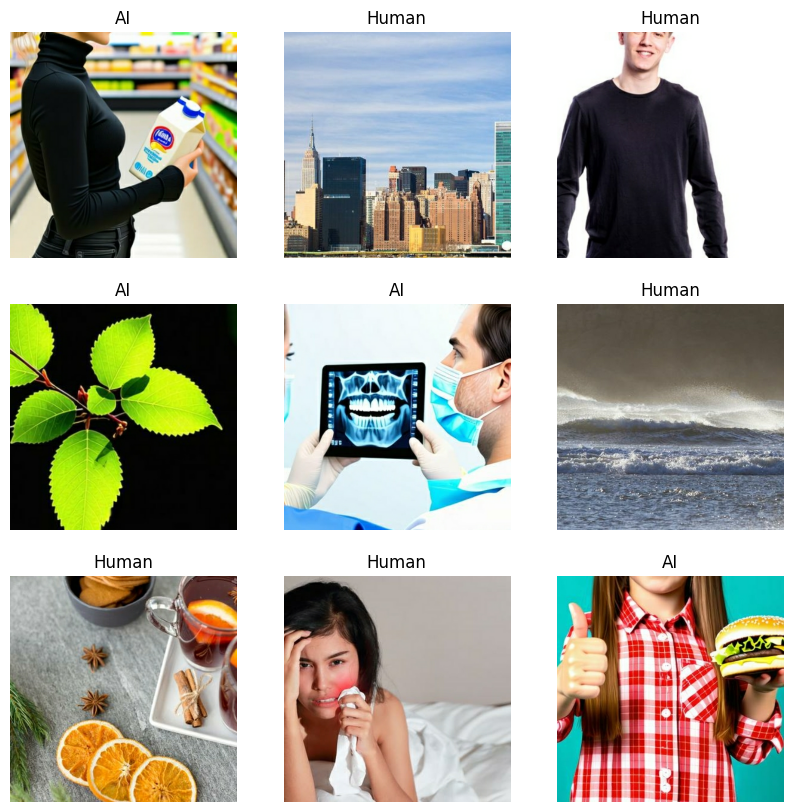

In [8]:

image_batch, label_batch = next(iter(eff_val_ds))
print(image_batch[0].shape)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.70980394..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB dat

(224, 224, 3)


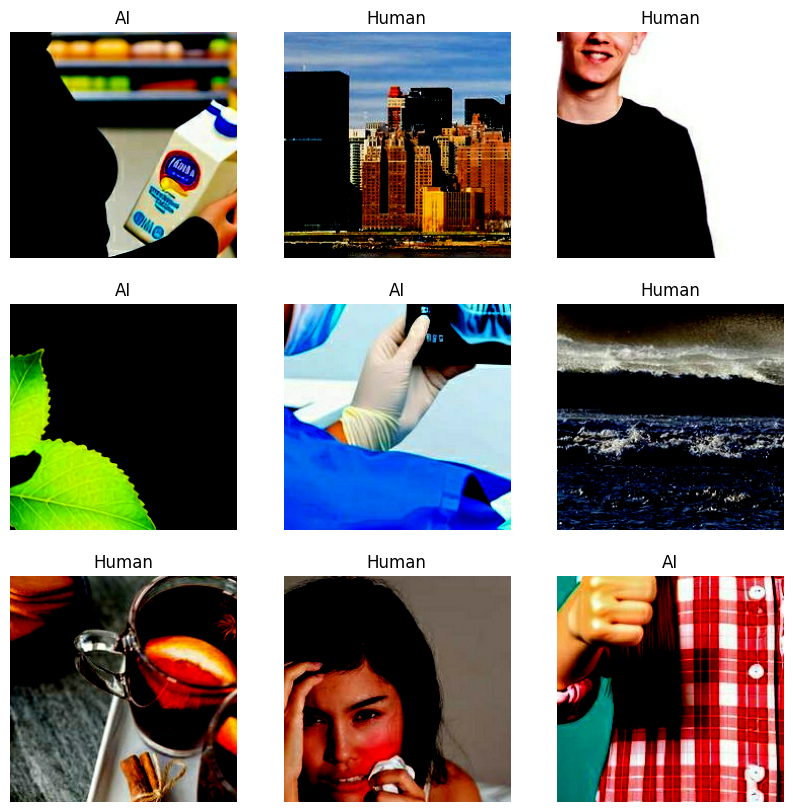

In [9]:

image_batch, label_batch = next(iter(res_val_ds))
print(image_batch[0].shape)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

In [12]:
res_model=keras.saving.load_model("./models/resnet_tuned_best_v32131289_blur_nomix_focal.keras")
eff_model=keras.saving.load_model("./models/efficientnet_tuned_blur_no_cutmix.keras")

In [ ]:
res_pred=res_model.predict(res_train_ds)
eff_pred=eff_model.predict(eff_train_ds)

TypeError: '_RepeatDataset' object is not subscriptable